In [1]:
import torch
from torch.utils.data import DataLoader
from utils.data_loading import BasicDataset
from utils.dice_score import dice_coeff
from pathlib import Path
from unet import UNet
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

def preprocess(pil_img, is_mask):
    import numpy as np
    w, h = pil_img.size
    newW, newH = int(1 * w), int(1 * h)
    assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
    pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
    img_ndarray = np.asarray(pil_img)

    if img_ndarray.ndim == 2 and not is_mask:
        img_ndarray = img_ndarray[np.newaxis, ...]
    elif not is_mask:
        img_ndarray = img_ndarray.transpose((2, 0, 1))

    if not is_mask:
        img_ndarray = img_ndarray / 255

    if(is_mask):
        # print(img_ndarray == 2)
        img_ndarray[img_ndarray <= 50] = 0
        img_ndarray[img_ndarray > 50] = 1

    return img_ndarray

def get_image_from_path(img_path, mask_path):
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    img = preprocess(img, is_mask=False)
    mask = preprocess(mask, is_mask=True)

    return torch.as_tensor(img.copy()).float().contiguous(), torch.as_tensor(mask.copy()).float().contiguous(),

def eval_by_path(folder="dataset/aerial_raw_250",img_name="513647232_0_0.jpg", return_pil=True):
    with torch.no_grad():
        # img_path = "dataset/aerial_raw_250/imgs/513647232_0_0.jpg"
        # mask_path = "dataset/aerial_raw_250/masks/513647232_0_0.jpg"
        img_path = f"{folder}/imgs/{img_name}"
        mask_path = f"{folder}/masks/{img_name}"
        image, mask_true = get_image_from_path(img_path, mask_path)
        ### create a batch of 1
        # torch.Size([3, 249, 249]) => torch.Size([1, 3, 249, 249])
        image = image.unsqueeze(dim=0)
        mask_true = mask_true.unsqueeze(dim=0)

        ### Actual Prediction
        # The convertion is followed the evaluate.py
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        # Predict
        mask_pred = net(image)
        # torch.Size([1, 2, 249, 249]) => torch.Size([1, 249, 249])
        mask_pred = mask_pred.argmax(dim=1)
        # Get Dice Score
        dice_score = dice_coeff(mask_pred, mask_true, reduce_batch_first=False).item()
        
        # .squeeze for [1,249,249] => [249,249]
        image = image.cpu().squeeze()
        mask_true = mask_true.cpu().squeeze().float()
        mask_pred = mask_pred.cpu().squeeze().float()
        if(return_pil):
            transform = T.ToPILImage()
            image = transform(image)
            mask_true = transform(mask_true)
            mask_pred = transform(mask_pred)
            image.filename = img_path
            mask_true.filename = mask_path
            mask_pred.filename = f"dice: {dice_score}"
        return image, mask_true, mask_pred, dice_score

def display_images(
    images, 
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):
    import textwrap, os
    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size); 

In [2]:
folder = "dataset"

targets = "aerial_raw_250"
# targets = "NB_raw_100"
# targets = "PB_raw_100"

device = 'cpu'
weight = Path(f'./checkpoints/{targets}_5epochs.pth')
net = UNet(n_channels=3, n_classes=2, bilinear=True)
net.load_state_dict(torch.load(weight, map_location=device))
net.to(device)
_ = net.eval()

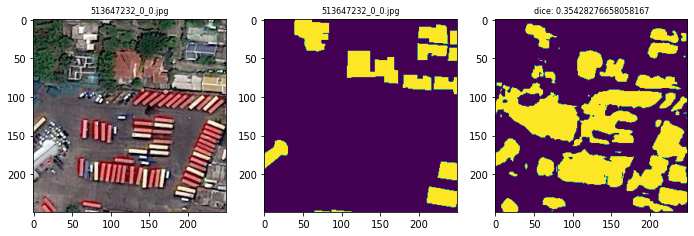

In [3]:
img_name = "513647232_0_0.jpg"
image, mask_true, mask_pred, dice_score = eval_by_path(folder=f"{folder}/{targets}",img_name=img_name)
display_images([image,mask_true,mask_pred])


In [4]:
import os
save_folder = f"{folder}/{targets}/preds/"
if(os.path.exists(save_folder) == False):
    os.mkdir(save_folder)
mask_pred.save(f"{folder}/{targets}/preds/{os.path.splitext(img_name)[0]}.png")